# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper as helper



# Getting the dataset

In [9]:
!curl 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip' \
  -H 'Connection: keep-alive' \
  -H 'Upgrade-Insecure-Requests: 1' \
  -H 'User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36' \
  -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9' \
  -H 'Sec-GPC: 1' \
  -H 'Sec-Fetch-Site: same-site' \
  -H 'Sec-Fetch-Mode: navigate' \
  -H 'Sec-Fetch-User: ?1' \
  -H 'Sec-Fetch-Dest: document' \
  -H 'Referer: https://www.microsoft.com/' \
  -H 'Accept-Language: en-GB,en-US;q=0.9,en;q=0.8' \
  -H 'Cookie: ak_bmsc=7686112CFD358C3754C15ED2601A9D90~000000000000000000000000000000~YAAQn24/FxkquCV9AQAA5tucdg02G98/CAGgyR3WQYX+KSRCz/UGXVHIsNPPBrvCi5juCnoulprGCPHJPoipxut4xiqK2mKMQtp8z4szt1DtLg4nC/69itS3ukIflbh8kT6QCuBt54yh9t/28siwJV1iDi04WZOprMOwUkrQFnqHe/BTQFd6pEdz7OJVdHikF5+//pAbkruwRTXXCwFs0tTnoDxK7amyg1HQcM04GHe1+XnZzc5PLtZrXNhCUGKLuXDwhdQbdS6QlvRogVnJxijeqBQFIdLfWdFCf/JuqaH2Z70Pg+UjwtadLnXwcsWGorKwW65k1Ja02Y9+K5fIxN02fMzXTnkLce6GjUSQFycmGf73C8OzC+NA5uRjtGOaevmDeTqgMJ4VYkMyvWVZ; at_check=true; AMCVS_EA76ADE95776D2EC7F000101%40AdobeOrg=1; MC1=GUID=5bf0b39b032a44eca026bf6576f76468&HASH=5bf0&LV=202112&V=4&LU=1638372533400; MS0=e3ab49cf93374ecf82a0c2ca5282af52; AMCV_EA76ADE95776D2EC7F000101%40AdobeOrg=1585540135%7CMCIDTS%7C18963%7CMCMID%7C88185699065173201587880019754963620679%7CMCAID%7CNONE%7CMCOPTOUT-1638379750s%7CNONE%7CvVersion%7C4.4.0; mbox=session#85e5c8ebcd3e4b068aa72faa58265211#1638374393|PC#85e5c8ebcd3e4b068aa72faa58265211.31_0#1672559249; bm_sv=7D9D2860CEB674D6883C6B3F475726EB~JSbt3Ak6Wj5ea03U4NSOu9xCSCNrJeXxaJ28yb01T59tgHHwOtwxRZYtZcaXITolB6MYQzGNKsYrtnMmTWtBU9mZQKjwsfsLPa0tr4mfQFQnY3bHd/y66bOxoUD9uf3KB4yIhKbZrgTtk6z+bhbP0pA8385q/tJLYlS6mvJh3PA=; MS-CV=rTu91cgOGEeMqQxt.17' \
  --compressed \
  --output "data.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   146M      0  0:00:05  0:00:05 --:--:--  150M


In [10]:
DATA_LOCATION = 'Cat_Dog_data'

import zipfile
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_LOCATION)

In [11]:
DATA_LOCATION = 'Cat_Dog_data'
DATA_LOCATION = os.path.join(DATA_LOCATION, 'PetImages')

The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has its own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). I've also split it into a training set and test set.

### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

There are plenty of transforms available, I'll cover more in a bit and you can read through the [documentation](http://pytorch.org/docs/master/torchvision/transforms.html). 

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Load images from the `Cat_Dog_data/train` folder, define a few transforms, then build the dataloader.

In [12]:
transform = transforms.Compose(
    [transforms.Resize(255),
     transforms.CenterCrop(224),
     transforms.ToTensor()]
)# TODO: compose transforms here
dataset = datasets.ImageFolder(DATA_LOCATION, transform=transform)# TODO: create the ImageFolder
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)# TODO: use the ImageFolder dataset to create the DataLoader

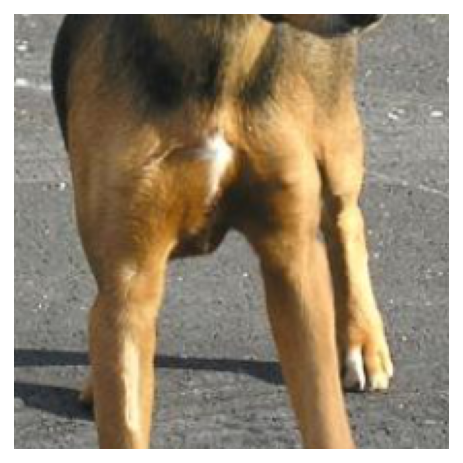

In [13]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

In [36]:
images.shape

torch.Size([32, 3, 224, 224])

If you loaded the data correctly, you should see something like this (your image will be different):

<img src='assets/cat_cropped.png' width=244>

## Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.

>**Exercise:** Define transforms for training data and testing data below. Leave off normalization for now.

In [27]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([
  transforms.Resize(255),
  transforms.CenterCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(30),
  transforms.ToTensor()
])

test_transforms = transforms.Compose([
  transforms.Resize(255),
  transforms.CenterCrop(224),
  transforms.ToTensor()
])


# Pass transforms in here, then run the next cell to see how the transforms look
all_data = datasets.ImageFolder(DATA_LOCATION)
train_dataset_size = int(0.8 * len(all_data))
test_dataset_size = int(len(all_data) - train_dataset_size)

train_data, test_data = torch.utils.data.random_split(all_data, [train_dataset_size, test_dataset_size])
train_data.dataset.transform = train_transforms
test_data.dataset.transform = test_transforms

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

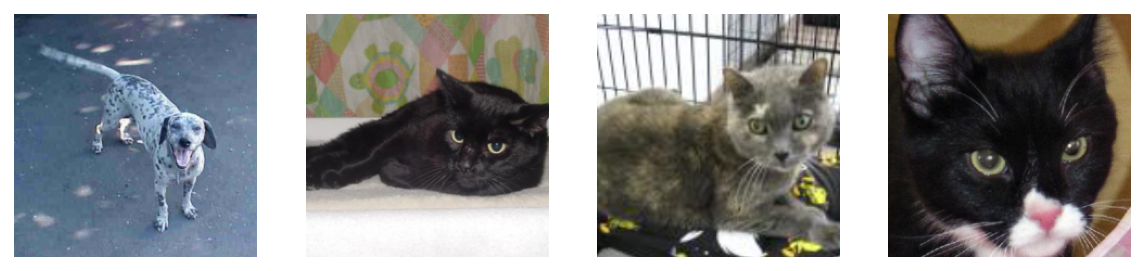

In [32]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii+4], ax=ax, normalize=False)

In [48]:
images.view(images.shape[0], -1).shape

torch.Size([32, 150528])

Your transformed images should look something like this.

<center>Training examples:</center>
<img src='assets/train_examples.png' width=500px>

<center>Testing examples:</center>
<img src='assets/test_examples.png' width=500px>

At this point you should be able to load data for training and testing. Now, you should try building a network that can classify cats vs dogs. This is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. To be honest, you probably won't get it to work with a fully-connected network, no matter how deep. These images have three color channels and at a higher resolution (so far you've seen 28x28 images which are tiny).

In the next part, I'll show you how to use a pre-trained network to build a model that can actually solve this problem.

In [86]:
# Curropted images
!rm Cat_Dog_data/PetImages/Cat/666.jpg
!rm Cat_Dog_data/PetImages/Dog/11702.jpg

rm: cannot remove 'Cat_Dog_data/PetImages/Cat/666.jpg': No such file or directory
rm: cannot remove 'Cat_Dog_data/PetImages/Dog/11702.jpg': No such file or directory


In [87]:
# Optional TODO: Attempt to build a network to classify cats vs dogs from this dataset

import os


train_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

DATA_LOCATION = 'Cat_Dog_data'
DATA_LOCATION = os.path.join(DATA_LOCATION, 'PetImages')

all_data = datasets.ImageFolder(DATA_LOCATION)
train_dataset_size = int(0.8 * len(all_data))
test_dataset_size = int(len(all_data) - train_dataset_size)

train_data, test_data = torch.utils.data.random_split(all_data, [train_dataset_size, test_dataset_size])
train_data.dataset.transform = train_transforms
test_data.dataset.transform = test_transforms


trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)



In [88]:
images, labels = next(iter(trainloader))
images.view(images.shape[0], -1).shape

torch.Size([32, 150528])

In [96]:
import torch.nn.functional as F
from torch import nn
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(150528, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 120)
        self.fc5 = nn.Linear(120, 2)

    def forward(self, x):
        # Flatten
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x), dim=1)
        return x


In [90]:
def to_accuracy(y_pred, y_true):
  if len(y_pred.shape) == 2:
    y_pred = torch.argmax(y_pred, axis=1)
  comparision = (y_pred == y_true).type(torch.FloatTensor)
  accuracy = torch.mean(comparision)
  return accuracy

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [97]:
from tqdm import tqdm
from torch import optim

model = Model()
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [106]:
epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(1, epochs+1):
    running_loss = 0
    running_accuracy = 0
    try:
      for images, labels in tqdm(trainloader):

          optimizer.zero_grad()
          images = images.to(device)
          labels = labels.to(device)
          log_ps = model(images)
          loss = criterion(log_ps, labels)
          loss.backward()
          optimizer.step()
          running_accuracy += to_accuracy(torch.exp(log_ps), labels)
          running_loss += loss.item()

      else:
          test_loss = 0
          accuracy = 0

          # Turn off gradients for validation, saves memory and computations
          with torch.no_grad():
              model.eval()
              for images, labels in testloader:
                  images = images.to(device)
                  labels = labels.to(device)
                  log_ps = model(images)
                  test_loss += criterion(log_ps, labels)

                  ps = torch.exp(log_ps)
                  top_p, top_class = ps.topk(1, dim=1)
                  equals = top_class == labels.view(*top_class.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))

          model.train()

          train_losses.append(running_loss/len(trainloader))
          test_losses.append(test_loss/len(testloader))
          train_acc = running_accuracy/len(trainloader)

          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                "Test Loss: {:.3f}.. ".format(test_losses[-1]),
                "Test Accuracy: {:.3f}".format(accuracy/len(testloader)),
                "Train Accuracy: {:.3f}".format(train_acc))
    except Exception as e:
      print(e)

 45%|████▍     | 280/625 [01:29<01:53,  3.04it/s]/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corru

Epoch: 1/10..  Training Loss: 0.686..  Test Loss: 0.671..  Test Accuracy: 0.577 Train Accuracy: 0.581


 12%|█▏        | 74/625 [00:23<02:57,  3.11it/s]


KeyboardInterrupt: ignored

In [119]:
torch.save(model.state_dict(), 'cat_dog_classifier.pth')

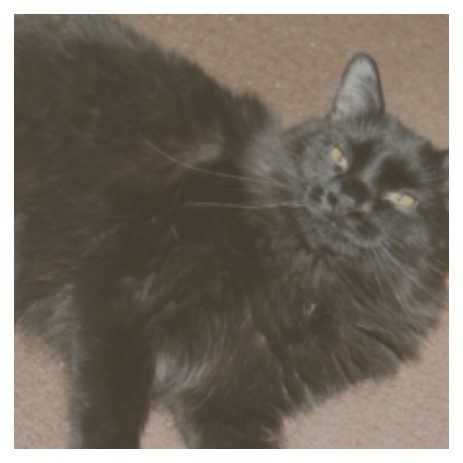

In [129]:
images, labels = next(iter(testloader))
img = images[4]
helper.imshow(img)

In [130]:
i = img.view(1,3,224,224).cuda()
out = model(i)
print(torch.exp(out))

tensor([[0.6430, 0.3570]], device='cuda:0', grad_fn=<ExpBackward0>)


In [131]:
print(labels[4])

tensor(0)
